Populating the interactive namespace from numpy and matplotlib
finding map estimate...
map estimate:
{'theta_stickbreaking': array([ -6.93139848e-01,  -1.28143809e-09]), 'beta_O_stickbreaking': array([ -2.52084154e-08,   5.10826069e-01]), 'beta_X_stickbreaking': array([ -4.96832802e-08,   2.07027335e-11]), 'beta_Neither_stickbreaking': array([ 0.69314477,  1.60945992])}
NUTS
sample
 [-----------------100%-----------------] 2000 of 2000 complete in 12.0 sec

`%matplotlib` prevents importing * from pylab and numpy


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000333B29B0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000000337A7B38>]], dtype=object)

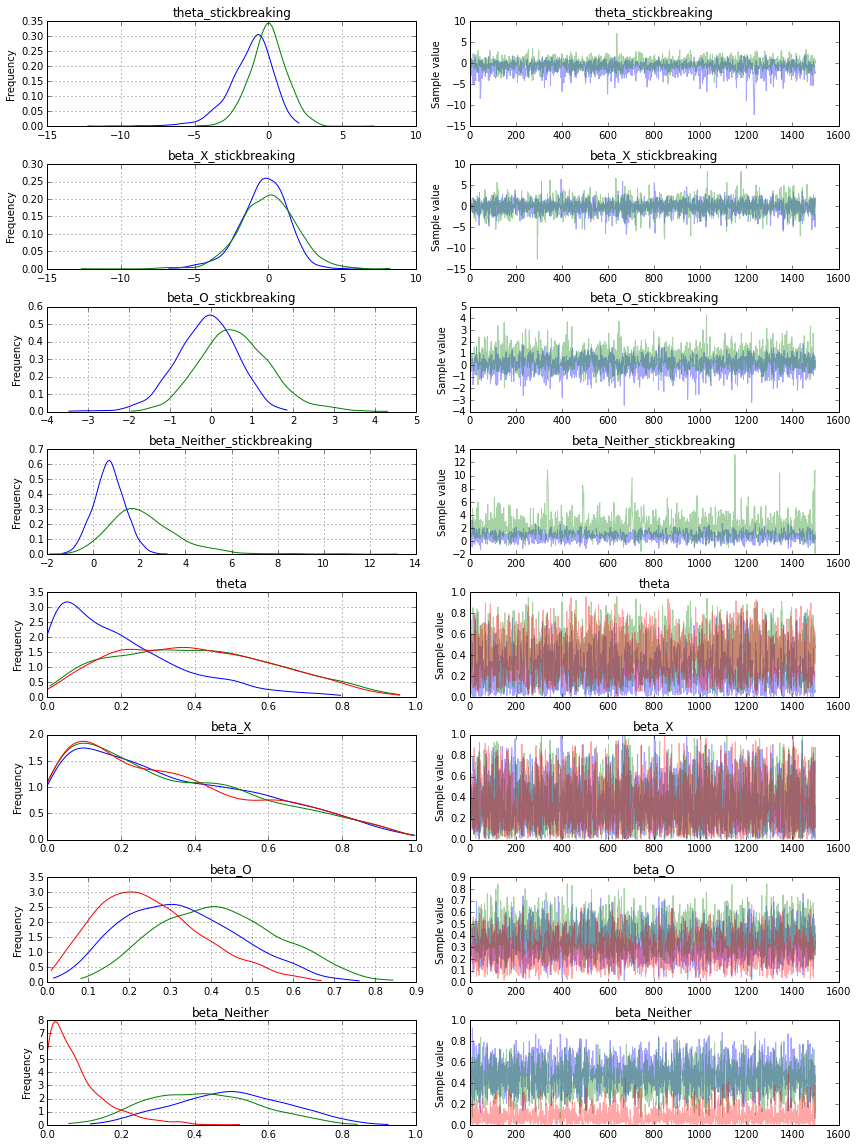

In [3]:
%pylab inline
import numpy as np
from pymc3 import Model, Dirichlet, find_MAP, NUTS, sample, Multinomial, traceplot
from scipy import optimize

model = Model()
X, O, Neither = "X", "O", "Neither"
WINNER = (X, O, Neither,)
TOKENS = (X, O, Neither,)

# prior observations. Mappings of variables, W, T_1, T_2, ..., T_9
games = [
    {
      "W": Neither,
      "T1": X,
      "T2": O,
      "T3": X,
      "T4": X,
      "T5": O,
      "T6": O,
      "T7": O,
      "T8": X,
      "T9": X,
    },
    {
      "W": O,
      "T1": O,
      "T2": O,
      "T3": Neither,
      "T4": O,
      "T5": X,
      "T6": X,
      "T7": O,
      "T8": X,
      "T9": Neither,
    },
]

def w_ind(s):
    """
    Maps a symbol in WINNER to an index, for consistency
    :param s: A symbol in WINNER
    :return: an integer index
    """
    return WINNER.index(s)

def t_ind(t):
    """
    Maps a symbol in TOKENS to an index, for consistency
    :param t: A symbol in TOKENS
    :return: an integer index
    """
    return TOKENS.index(t)

with model:
    theta = Dirichlet("theta", np.ones(3), shape=3)
    beta = {t: Dirichlet(name="beta_%s" % t, a=np.ones(3), shape=3) for t in WINNER}

    for g_ind, game in enumerate(games):
        wobs = [0, 0, 0]
        wobs[w_ind(game["W"])] += 1
        w = Multinomial("w_%s" % g_ind, 1, theta, observed=wobs)
        for pos in range(1, 10):
            tobs = [0, 0, 0]
            tobs[t_ind(game["T%s" % pos])] += 1
            t = Multinomial("t_g%s_%s" % (g_ind, pos), 1, beta[game["W"]], observed=tobs)

    print("finding map estimate...")
    map_estimate = find_MAP(fmin=optimize.fmin_powell)

    print("map estimate:")
    print(map_estimate)

    print("NUTS")
    step = NUTS(scaling=map_estimate)

    print("sample")
    hierarchical_trace = sample(2000, step, start=map_estimate)

traceplot(hierarchical_trace[500:])